In [112]:
import numpy as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams["figure.figsize"]= 10, 5

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Preprocessing

In [113]:
bmw = pd.read_csv("bmw.csv")

In [114]:
bmw.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,5 Series,2014,11200,Automatic,67068,Diesel,125,57.6,2.0
1,6 Series,2018,27000,Automatic,14827,Petrol,145,42.8,2.0
2,5 Series,2016,16000,Automatic,62794,Diesel,160,51.4,3.0
3,1 Series,2017,12750,Automatic,26676,Diesel,145,72.4,1.5
4,7 Series,2014,14500,Automatic,39554,Diesel,160,50.4,3.0


In [115]:
bmw.isnull().sum()

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [116]:
bmw.shape

(10781, 9)

In [117]:
bmw.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

### Plot categorical features

<Figure size 720x360 with 0 Axes>

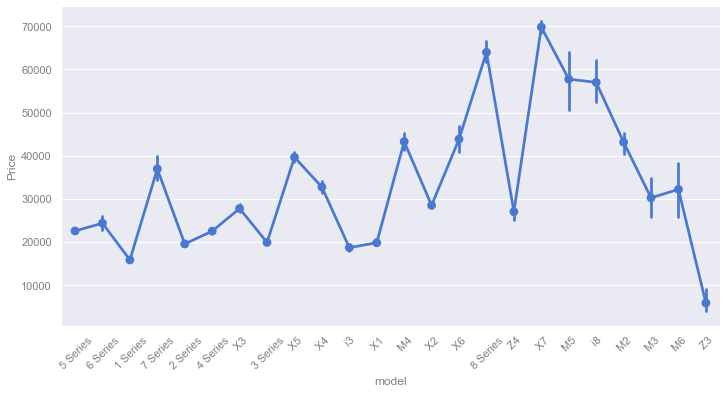

<Figure size 720x360 with 0 Axes>

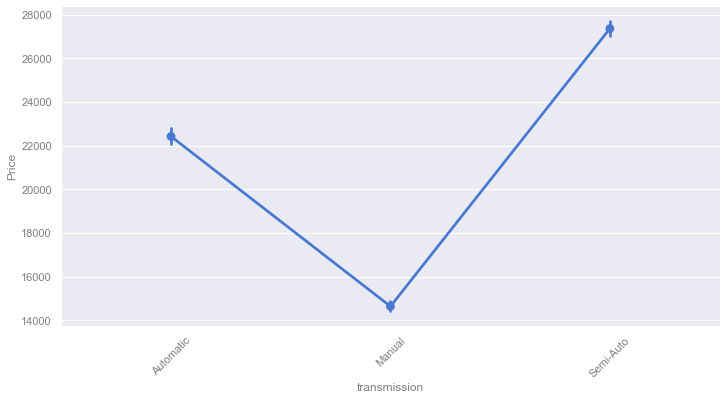

<Figure size 720x360 with 0 Axes>

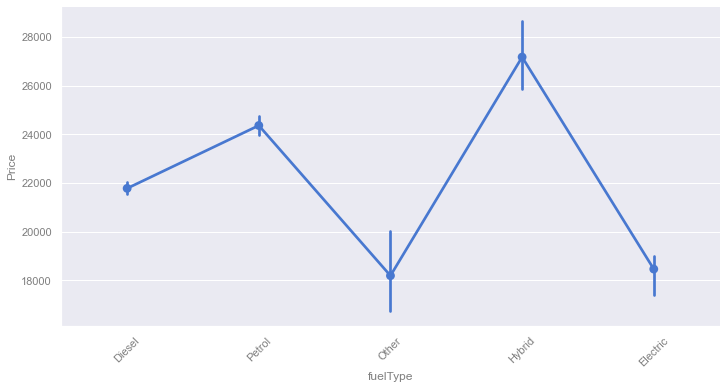

In [118]:
for i, col in enumerate(["model", "transmission", "fuelType"]):
    plt.figure(i)
    sns.catplot(x=col, y="price", data=bmw, kind="point", aspect=2)
    plt.ylabel("Price", fontdict={"color":"grey"})
    plt.xlabel(col, fontdict={"color":"grey"})
    plt.xticks(rotation= 45)
    plt.tick_params(axis='both', colors='grey')
    plt.show()

### Plot continuous features

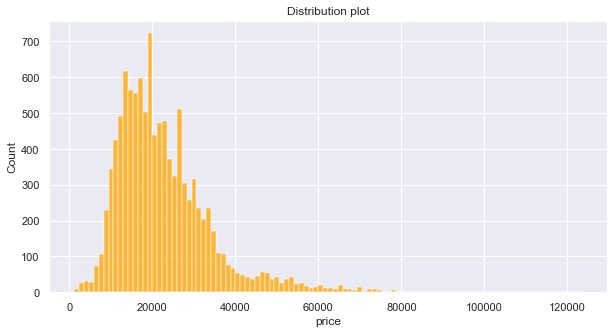

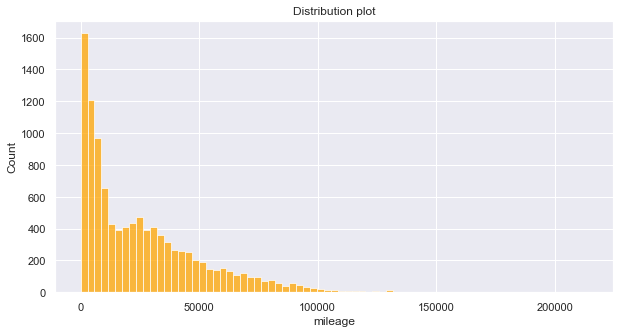

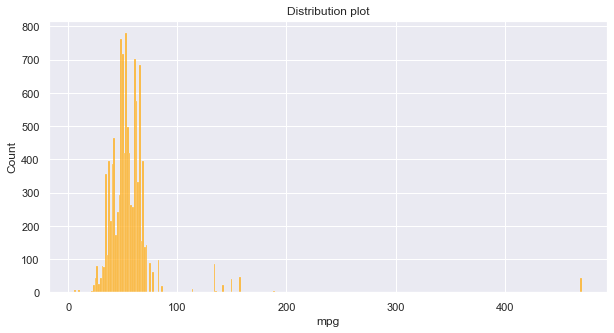

In [119]:
for i in ["price", "mileage", "mpg"]:
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.histplot(bmw[i], kde=False, color="orange")
    plt.title("Distribution plot")
    plt.show()

### We can detect a lot of outliers from the graphs above

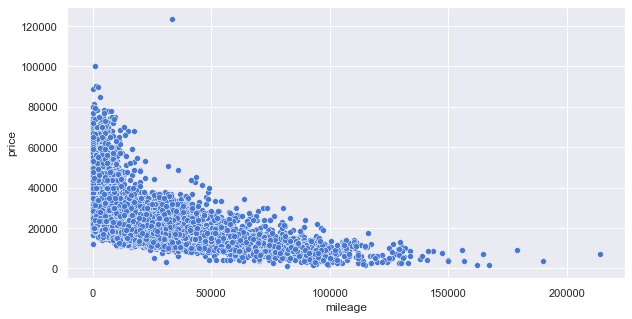

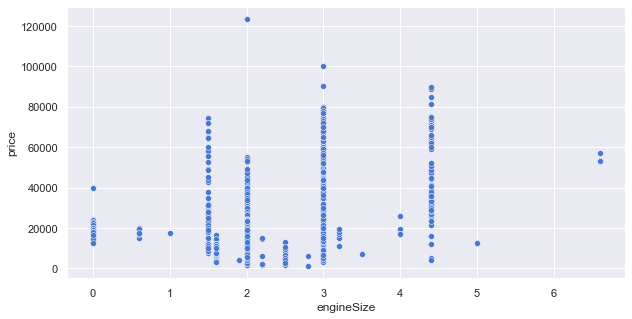

In [120]:
for i in ["mileage", "engineSize"]:
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.scatterplot(bmw[i], bmw["price"])
    plt.show()

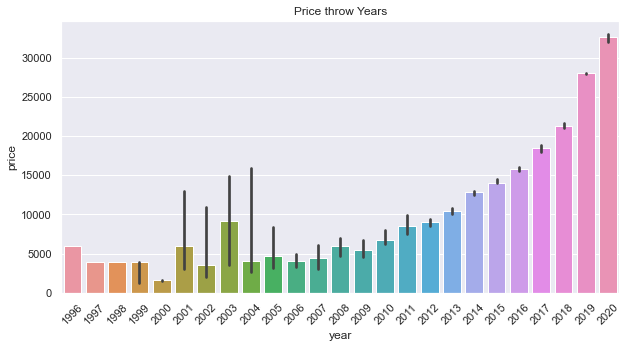

In [121]:
sns.barplot(x='year', y='price', data=bmw, estimator=np.median)
plt.xticks(rotation= 45)
plt.title("Price throw Years")
plt.show()

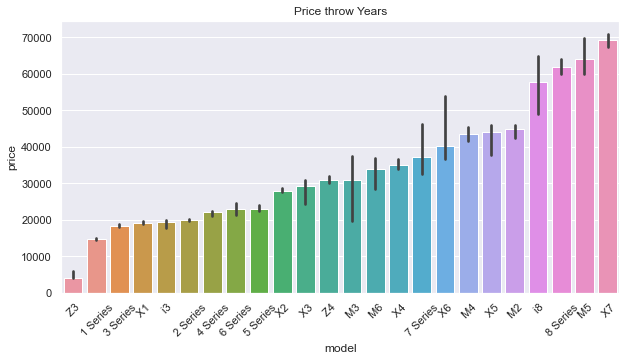

In [122]:
result = bmw.groupby(["model"])['price'].aggregate(np.median).reset_index().sort_values('price')
sns.barplot(x='model', y='price', data=bmw,estimator=np.median, order=result["model"])
plt.xticks(rotation= 45)
plt.title("Price throw Years")
plt.show()

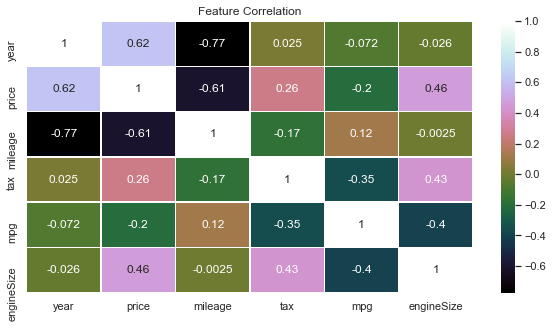

In [123]:
sns.heatmap(bmw.corr(), annot = True, linewidths=.5, cmap="cubehelix")
plt.title("Feature Correlation")
plt.show()

### Moreover we can see the existing correlation  between "price" the variable we want to predict and other variables

### Fix the outliers

In [124]:
bmw["price"].clip(upper=bmw["price"].quantile(0.99), inplace=True)
bmw["mileage"].clip(upper=bmw["mileage"].quantile(0.985), inplace=True)
bmw["mpg"].clip(upper=bmw["mpg"].quantile(0.98), inplace=True)

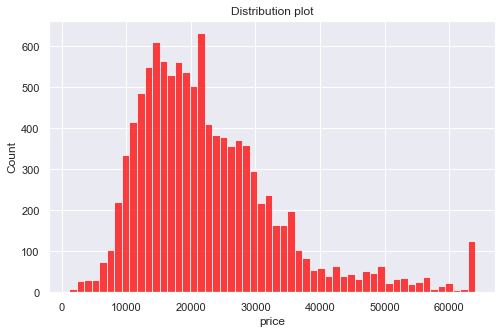

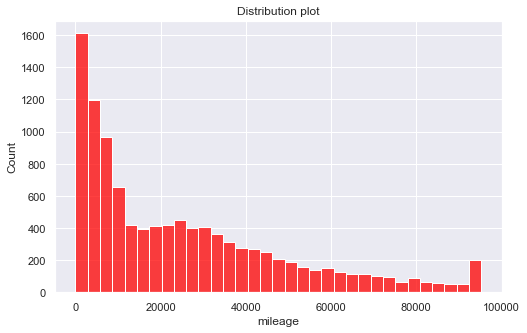

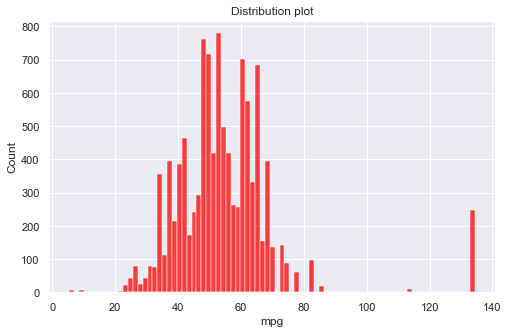

In [125]:
for i in ["price", "mileage", "mpg"]:
    plt.figure(figsize = (8, 5))
    plt.subplot(111)
    plt.title("Distribution plot")
    sns.set(style = 'darkgrid', palette= 'muted')
    sns.histplot(bmw[i], kde=False, color="red")
    plt.show()

### There is a right skewness(positive skewness) which will be fixed with the scaling process later

## Encoding

In [126]:
bmw["model"] = bmw["model"].str.lstrip()
fuel_type_dict = {'Diesel': 0, 'Petrol': 1, "Hybrid": 2, "Electric": 3, "Other": 4}
model_dict = {'1 Series': 1, '2 Series': 2, "3 Series": 3, "4 Series": 4, "5 Series": 5, '6 Series': 6, '7 Series': 7, "8 Series": 8,
              'X1': 11, 'X2': 12, "X3": 13, "X4": 14, "X5": 15, 'X6': 16, 'X7': 17,
              'M2': 22, 'M3': 23, "M4": 24, "M5": 25, "M6": 26,
              'Z3': 33, 'Z4': 34,
              "i3": 43, "i8": 48}
transmission_dict = {'Manual': 0, 'Semi-Auto': 1, "Automatic": 2}
bmw["fuelType"] = bmw['fuelType'].map(fuel_type_dict)
bmw["model"] = bmw['model'].map(model_dict)
bmw["transmission"] = bmw['transmission'].map(transmission_dict)

## Train-test-split

In [127]:
features = bmw.drop(["price"], axis=1)
target = bmw["price"]

In [128]:
tr_features, x_test, tr_labels, y_test = train_test_split(features, target, test_size = 0.25, random_state = 42)
val_features, te_features, val_labels, te_labels = train_test_split(x_test, y_test, test_size = 0.33, random_state = 42)

In [129]:
for dataset in [tr_labels, val_labels, te_labels]:
    print(round(len(dataset) / len(target), 2))

0.75
0.17
0.08


## Scaling

In [130]:
ss = StandardScaler()
tr_features = ss.fit_transform(tr_features)
val_features = ss.transform(val_features)
te_features = ss.transform(te_features)

# Machine learning- Training models

In [131]:
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from sklearn. model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from time import time

### Define a function that prints results and depicts the performance of the model in the training set and test set

In [132]:
def print_results(results):
    print("BEST PARAMS: {}\n".format(results.best_params_))
    
    
    train_means=[]
    test_means=[]
    train_means.append(results.cv_results_["mean_train_score"])
    test_means.append(results.cv_results_["mean_test_score"])
    train_out = np.concatenate(train_means).ravel().tolist()
    test_out = np.concatenate(test_means).ravel().tolist()
    
    testMeans = results.cv_results_["mean_test_score"]
    stds = results.cv_results_["std_test_score"]
    for testMeans, std, params in zip(testMeans, stds, results.cv_results_["params"]):
        print("{} (+/-{}) for {}".format(round(testMeans, 3), round(std*2, 3), params))
    
    values = [i for i in range(1, 13)]
    plt.plot(values, train_out, '-o', label='Train')
    plt.plot(values, test_out, '-o', label='Test')
    plt.legend()
    plt.show()
    

# Random Forest Regressor

BEST PARAMS: {'max_depth': 8, 'n_estimators': 100}

0.686 (+/-0.043) for {'max_depth': 2, 'n_estimators': 5}
0.689 (+/-0.042) for {'max_depth': 2, 'n_estimators': 50}
0.69 (+/-0.043) for {'max_depth': 2, 'n_estimators': 100}
0.856 (+/-0.007) for {'max_depth': 4, 'n_estimators': 5}
0.861 (+/-0.011) for {'max_depth': 4, 'n_estimators': 50}
0.861 (+/-0.01) for {'max_depth': 4, 'n_estimators': 100}
0.908 (+/-0.008) for {'max_depth': 6, 'n_estimators': 5}
0.915 (+/-0.007) for {'max_depth': 6, 'n_estimators': 50}
0.915 (+/-0.008) for {'max_depth': 6, 'n_estimators': 100}
0.932 (+/-0.008) for {'max_depth': 8, 'n_estimators': 5}
0.938 (+/-0.01) for {'max_depth': 8, 'n_estimators': 50}
0.938 (+/-0.01) for {'max_depth': 8, 'n_estimators': 100}


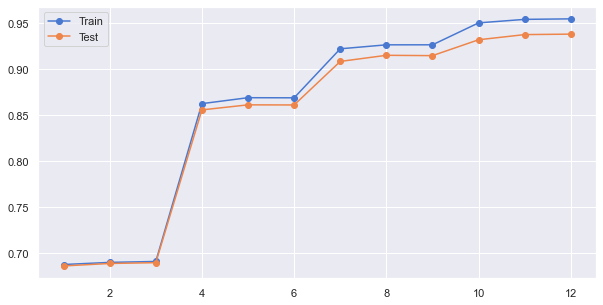

In [133]:
rf = RandomForestRegressor()

parameters= {
    'n_estimators':[5, 50, 100],
    'max_depth':[2, 4 , 6, 8]
}

cv = GridSearchCV(rf, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv) 

In [134]:
rf_best=cv.best_estimator_

# XG Boost Regressor

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}

0.896 (+/-0.018) for {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.911 (+/-0.015) for {'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}
0.923 (+/-0.013) for {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.934 (+/-0.011) for {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}
0.939 (+/-0.011) for {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100, 'objective': 'reg:squarederror'}
0.946 (+/-0.012) for {'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 150, 'objective': 'reg:squarederror'}
0.919 (+/-0.014) for {'learning_rate': 0.1

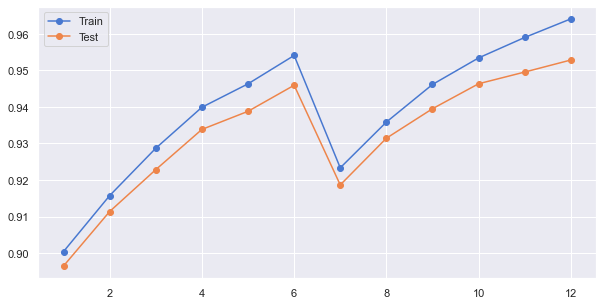

In [135]:
xgb = XGBRegressor()

parameters= {
    "objective": ["reg:squarederror"],
    'n_estimators':[100, 150],
    'learning_rate': [0.05, 0.1],
    'max_depth': [2, 3, 4],
    'min_child_weight': [1]
}

cv = GridSearchCV(xgb,parameters , cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv) 

In [136]:
xgb_best = cv.best_estimator_

# Multi-Layer Perceptron Regressor

BEST PARAMS: {'activation': 'relu', 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 1, 'max_iter': 700}

0.914 (+/-0.028) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'learning_rate_init': 1, 'max_iter': 700}
0.917 (+/-0.014) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'learning_rate_init': 1.2, 'max_iter': 700}
0.927 (+/-0.017) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'invscaling', 'learning_rate_init': 1.5, 'max_iter': 700}
0.917 (+/-0.009) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 1, 'max_iter': 700}
0.912 (+/-0.032) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 1.2, 'max_iter': 700}
0.918 (+/-0.018) for {'activation': 'relu', 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'learning_rate_init': 1.5, '

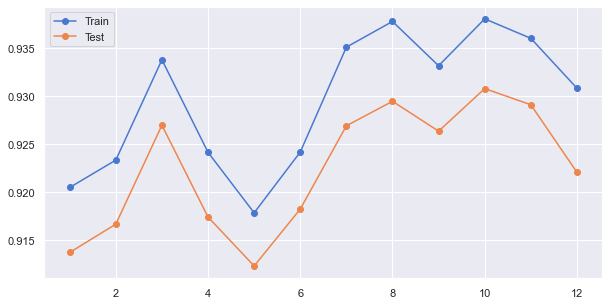

In [137]:
mlp = MLPRegressor()

parameters= {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ["relu"],
    "learning_rate": ["invscaling", "adaptive"],
    "learning_rate_init": [1, 1.2, 1.5],
    "max_iter": [700]
}

cv = GridSearchCV(mlp, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [138]:
mlp_best = cv.best_estimator_

# Gradient Boosting Regressor

BEST PARAMS: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

0.278 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 50}
0.436 (+/-0.023) for {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 100}
0.506 (+/-0.018) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
0.715 (+/-0.021) for {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
0.802 (+/-0.022) for {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 50}
0.858 (+/-0.019) for {'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 100}
0.924 (+/-0.011) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
0.94 (+/-0.013) for {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
0.895 (+/-0.011) for {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 50}
0.914 (+/-0.011) for {'learning_rate': 1, 'max_depth': 1, 'n_estimators': 100}
0.935 (+/-0.025) for {'learning_rate': 1, 'max_depth': 3, 'n_estimators': 50}
0.937 (+/-0.02) for {'learning_rate': 1, 'ma

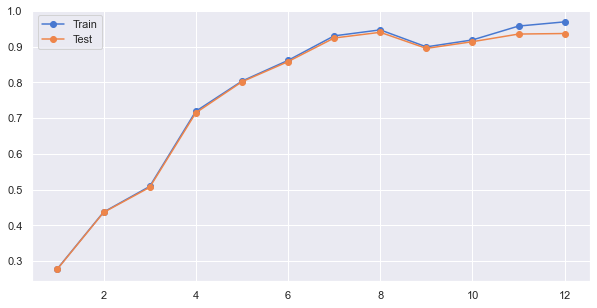

In [139]:
gb = GradientBoostingRegressor()

parameters= {
    'learning_rate':[0.01, 0.1, 1],
    'n_estimators':[50, 100],
    'max_depth':[1, 3]    
}

cv = GridSearchCV(gb, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv) 

In [140]:
gb_best = cv.best_estimator_

# Elastic Net

BEST PARAMS: {'alpha': 0.01, 'l1_ratio': 0.7, 'selection': 'random'}

0.773 (+/-0.011) for {'alpha': 0.001, 'l1_ratio': 0.7, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.001, 'l1_ratio': 0.7, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 0.001, 'l1_ratio': 0.9, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.001, 'l1_ratio': 0.9, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 0.01, 'l1_ratio': 0.7, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.01, 'l1_ratio': 0.7, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 0.01, 'l1_ratio': 0.9, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.01, 'l1_ratio': 0.9, 'selection': 'random'}
0.772 (+/-0.011) for {'alpha': 0.1, 'l1_ratio': 0.7, 'selection': 'cyclic'}
0.772 (+/-0.011) for {'alpha': 0.1, 'l1_ratio': 0.7, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 0.1, 'l1_ratio': 0.9, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.1, 'l1_ratio': 0.9, 'selection': 'random'}


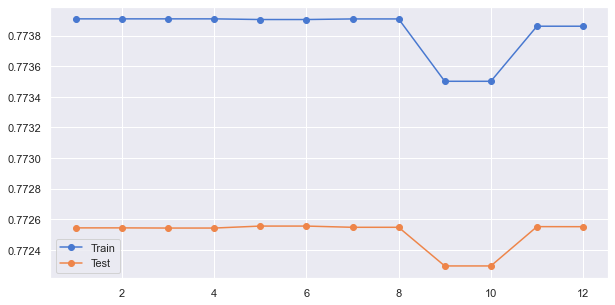

In [141]:
en = ElasticNet()

parameters= {
    "alpha": [0.001, 0.01, 0.1],
    "l1_ratio": [ 0.7, 0.9],
    "selection": ["cyclic", "random"]
}

cv = GridSearchCV(en, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [142]:
en_best = cv.best_estimator_

# Ridge

BEST PARAMS: {'alpha': 0.01, 'normalize': True, 'solver': 'svd'}

0.773 (+/-0.011) for {'alpha': 0.0001, 'normalize': True, 'solver': 'auto'}
0.773 (+/-0.011) for {'alpha': 0.0001, 'normalize': True, 'solver': 'svd'}
0.773 (+/-0.011) for {'alpha': 0.0001, 'normalize': True, 'solver': 'sparse_cg'}
0.773 (+/-0.011) for {'alpha': 0.001, 'normalize': True, 'solver': 'auto'}
0.773 (+/-0.011) for {'alpha': 0.001, 'normalize': True, 'solver': 'svd'}
0.773 (+/-0.011) for {'alpha': 0.001, 'normalize': True, 'solver': 'sparse_cg'}
0.773 (+/-0.011) for {'alpha': 0.01, 'normalize': True, 'solver': 'auto'}
0.773 (+/-0.011) for {'alpha': 0.01, 'normalize': True, 'solver': 'svd'}
0.773 (+/-0.011) for {'alpha': 0.01, 'normalize': True, 'solver': 'sparse_cg'}
0.769 (+/-0.012) for {'alpha': 0.1, 'normalize': True, 'solver': 'auto'}
0.769 (+/-0.012) for {'alpha': 0.1, 'normalize': True, 'solver': 'svd'}
0.769 (+/-0.012) for {'alpha': 0.1, 'normalize': True, 'solver': 'sparse_cg'}


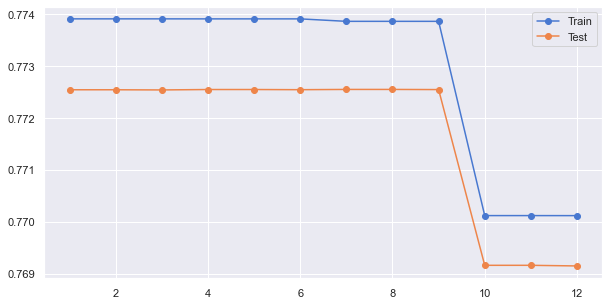

In [143]:
rd = Ridge()

parameters= {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "normalize": [True],
    "solver": ["auto", "svd", "sparse_cg"]
    
}

cv = GridSearchCV(rd, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [144]:
rd_best = cv.best_estimator_

# Lasso

BEST PARAMS: {'alpha': 0.01, 'normalize': True, 'selection': 'cyclic'}

0.773 (+/-0.011) for {'alpha': 1e-05, 'normalize': True, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 1e-05, 'normalize': True, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.001, 'normalize': True, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 0.001, 'normalize': True, 'selection': 'cyclic'}
0.773 (+/-0.011) for {'alpha': 0.01, 'normalize': True, 'selection': 'random'}
0.773 (+/-0.011) for {'alpha': 0.01, 'normalize': True, 'selection': 'cyclic'}
0.773 (+/-0.01) for {'alpha': 0.1, 'normalize': True, 'selection': 'random'}
0.773 (+/-0.01) for {'alpha': 0.1, 'normalize': True, 'selection': 'cyclic'}
0.773 (+/-0.01) for {'alpha': 0.25, 'normalize': True, 'selection': 'random'}
0.773 (+/-0.01) for {'alpha': 0.25, 'normalize': True, 'selection': 'cyclic'}
0.772 (+/-0.01) for {'alpha': 0.5, 'normalize': True, 'selection': 'random'}
0.772 (+/-0.01) for {'alpha': 0.5, 'normalize': True, 'selectio

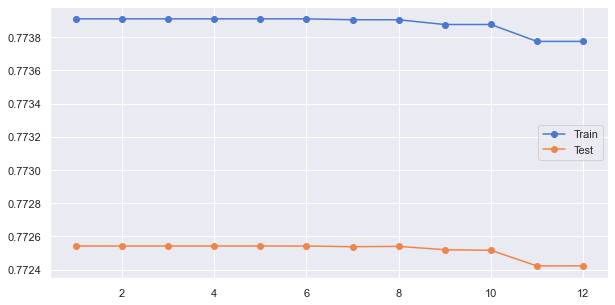

In [145]:
ls = Lasso()

parameters= {
    "alpha": [0.00001, 0.001, 0.01, 0.1, 0.25, 0.5],
    "normalize": [True],
    "selection": ["random", "cyclic"]
}

cv = GridSearchCV(ls, parameters, cv=5, return_train_score=True)
cv.fit(tr_features, tr_labels.values.ravel())

print_results(cv)

In [146]:
Lasso()

Lasso()

In [147]:
ls_best = cv.best_estimator_

### Aggregate trained models-Evaluating models on validation set

In [148]:
models= {"RF" : rf_best,
         "XGB": xgb_best,
         "MLP": mlp_best,
         "GB": gb_best,
         "EN": en_best,
         "RD": rd_best,
         "LS": ls_best}


### Define a function that calculates the scores of all the models as well as the latency of the model

In [149]:
def evaluate_model(name, model, features, labels):
    start = time()
    pred = model.predict(features)
    end = time()
    
    MAE= round(mean_absolute_error(labels, pred), 3)
    MSE= round(mean_squared_error(labels, pred), 3)
    R2= round(r2_score(labels, pred), 3)
    
    print("{} // MAE: {} // MSE: {} // R2: {} // Latency: {}ms \n".format(name,
                                                                          MAE,
                                                                          MSE,
                                                                          R2,
                                                                          round((end - start), 3)))

In [150]:
for name, mdl in models.items():
    evaluate_model(name, mdl, val_features, val_labels)

RF // MAE: 1882.747 // MSE: 6886295.18 // R2: 0.943 // Latency: 0.024ms 

XGB // MAE: 1607.11 // MSE: 5379778.54 // R2: 0.956 // Latency: 0.008ms 

MLP // MAE: 1976.449 // MSE: 7874945.78 // R2: 0.935 // Latency: 0.01ms 

GB // MAE: 1826.767 // MSE: 6976302.532 // R2: 0.942 // Latency: 0.003ms 

EN // MAE: 3626.511 // MSE: 25903645.919 // R2: 0.786 // Latency: 0.0ms 

RD // MAE: 3623.71 // MSE: 25907998.76 // R2: 0.786 // Latency: 0.001ms 

LS // MAE: 3627.898 // MSE: 25905792.874 // R2: 0.786 // Latency: 0.0ms 



# Evaluate best model on test set

In [151]:
evaluate_model("XGBoost Regressor", models["XGB"], te_features, te_labels)

XGBoost Regressor // MAE: 1704.188 // MSE: 6049912.507 // R2: 0.949 // Latency: 0.006ms 



### We trained a lot of models in the training dataset, found the best estimators for each model in order to perform very well,  evaluated the models in the validation set (unseen data), picked the model with the best performance and lastly we evaluated our best model (XG Boost) in the test set (unseen data) one more time.

### One last step will be to train the model in the whole dataset and it will be ready for use.